In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.discrete_fee_perfect_oracle import DiscreteFeePerfectOracle
from fee_algorithm.continuous_fee_perfect_oracle import ContinuousFeePerfectOracle
from fee_algorithm.fee_based_on_historical_price import FeeBasedOnHistoricalPrice

from copy import deepcopy

fee_algos_to_consider = {
    "fixed_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    "discrete_fee_perfect_oracle": DiscreteFeePerfectOracle(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
    "continuous_fee_perfect_oracle": ContinuousFeePerfectOracle(default_fee_rate=0.003), # 30 bps
    "fee_based_on_historical_price": FeeBasedOnHistoricalPrice(alpha=0.3, fee_in_increasing_deviation_direction=0.0045, fee_in_decreasing_deviation_direction=0.0015), # 45/15 bps
}

experiment_configs = {}

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_name = f"{period_alias}_{fee_algo_alias}"
        experiment_configs[experiment_name] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [3]:
from pprint import pprint

pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0),
                               end_time=datetime.datetime(2022, 11, 16, 12, 0),
                               A_symbol='ETH',
                               B_symbol='SHIB',
                               stable_coin_symbol='USDT',
                               candle_interval='5m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.003),
           informed_user=InformedUser(),
           uninformed_users=UninformedUsersConfig(uninformed_user=UninformedUser(mu=0.00016,
                                                                                 sigma=1e-05),
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           initial_pool_value=26263564,
           network_fee=5)


In [4]:
from experiments.run_experiment import run_experiment
from experiments.experiment import ExperimentResult
import numpy as np

experiment_results: dict[str, ExperimentResult] = {}


for experiment_name, experiment_config in experiment_configs.items():
    np.random.seed(0)
    experiment_results[experiment_name] = run_experiment(experiment_config)

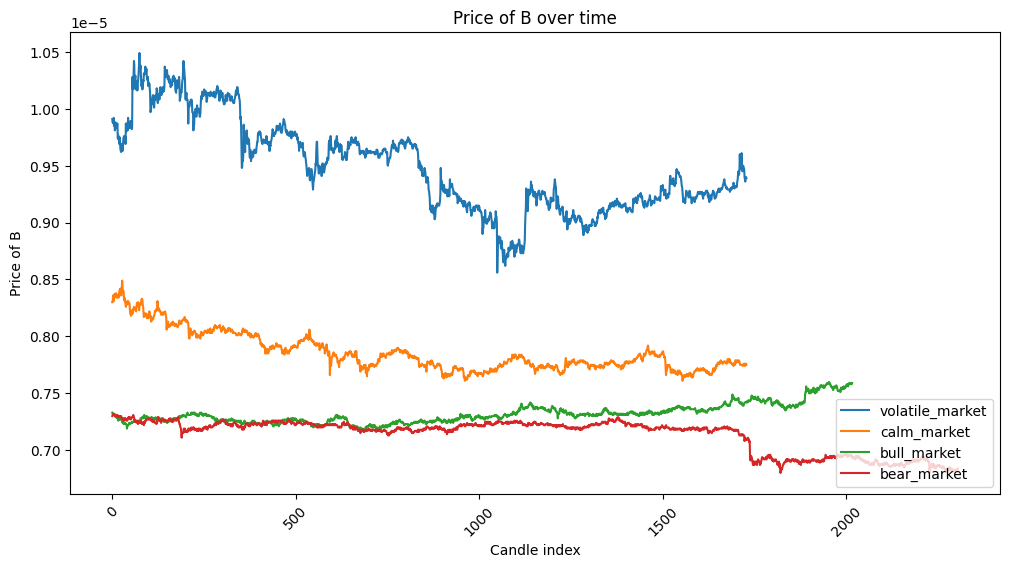

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_B"], label=period_alias)
    plt.title("Price of B over time")

plt.ylabel("Price of B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

### Results

In [6]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiment_summary

In [7]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    plot_participants_markouts(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )
    plot_impermanent_loss(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    summary = get_experiment_summary(
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    display(summary)

### Results for bull market

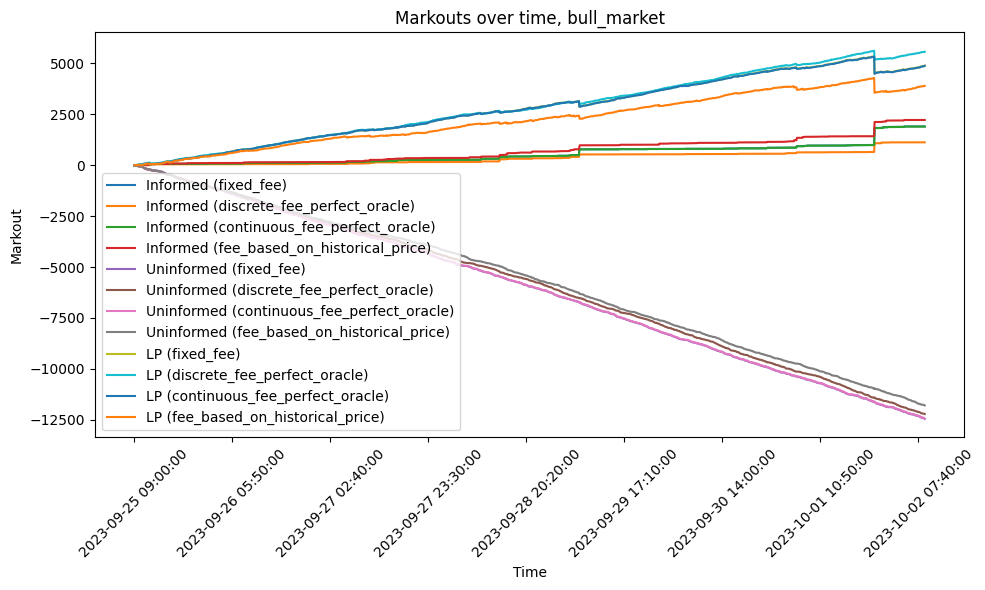

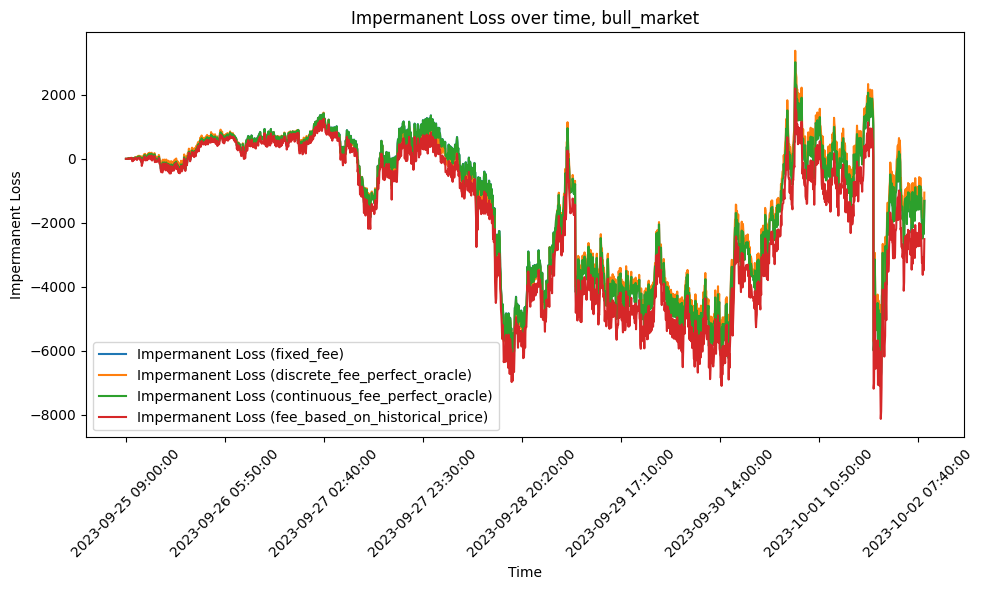

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,1906.931392,-12458.278204,4896.346812,-1303.367616
1,discrete_fee_perfect_oracle,1126.513633,-12219.971209,5573.457576,-1056.396634
2,continuous_fee_perfect_oracle,1899.936265,-12436.682969,4881.746705,-1318.774389
3,fee_based_on_historical_price,2223.872399,-11794.172184,3900.299785,-2511.709266


In [8]:
plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

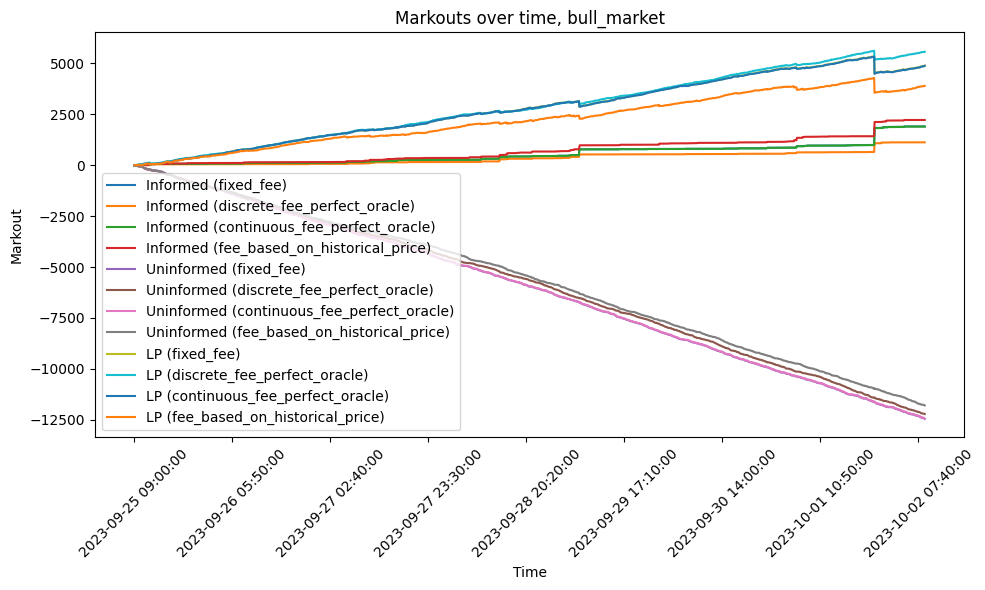

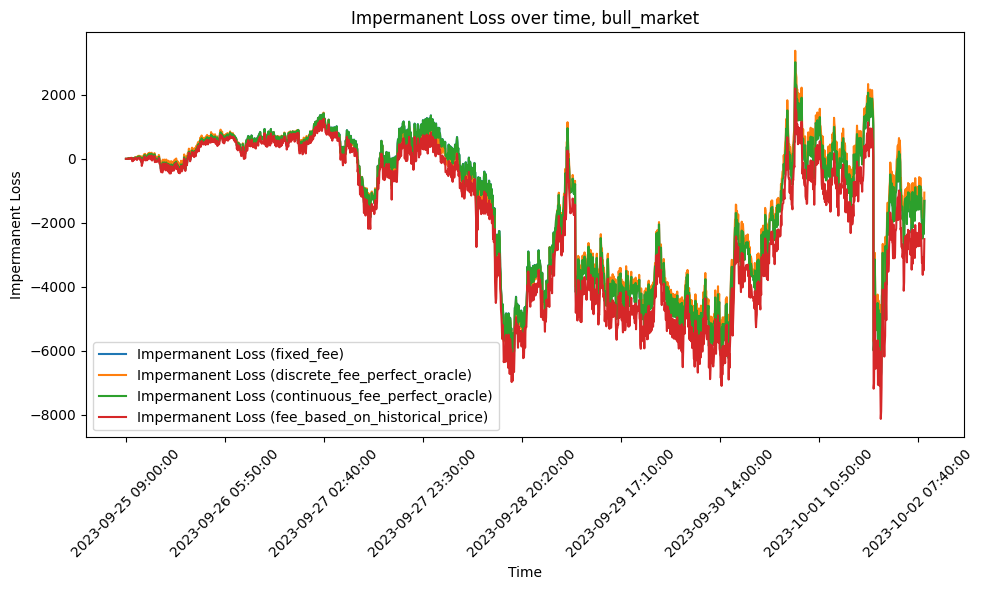

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,1906.931392,-12458.278204,4896.346812,-1303.367616
1,discrete_fee_perfect_oracle,1126.513633,-12219.971209,5573.457576,-1056.396634
2,continuous_fee_perfect_oracle,1899.936265,-12436.682969,4881.746705,-1318.774389
3,fee_based_on_historical_price,2223.872399,-11794.172184,3900.299785,-2511.709266


In [9]:
plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

In [10]:
plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

In [ ]:
plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

In [ ]:
plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

In [ ]:
plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))

In [ ]:
plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))

In [ ]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional

def plot_fee_algo_price_ema_vs_price(experiment_result: ExperimentResult, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    fee_algo_price_ema = []
    for snapshot in all_snapshots:
        fee_algo_price_ema.append(snapshot.pool.fee_algorithm.a_to_b_price_ema.average())
    
    real_prices = []
    for snapshot in all_snapshots:
        real_prices.append(snapshot.pool.get_a_to_b_exchange_price())
    

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, fee_algo_price_ema, label="EMA of price from fee algorithm")
    ax.plot(all_timestamps, real_prices, label="Real price")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend(loc="upper right")
    plt.title("EMA of price from fee algorithm vs real price")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

In [ ]:
plot_fee_algo_price_ema_vs_price(
    experiment_results["volatile_market_fee_based_on_historical_price"], first_updates=100
)

In [ ]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional

def plot_fee_algo_price_ema_vs_price(experiment_result: ExperimentResult, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    fee_algo_price_ema = []
    for snapshot in all_snapshots:
        fee_algo_price_ema.append(snapshot.pool.fee_algorithm.b_to_a_price_ema.average())
    
    real_prices = []
    for snapshot in all_snapshots:
        real_prices.append(snapshot.pool.get_b_to_a_exchange_price())
    

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, fee_algo_price_ema, label="EMA of price from fee algorithm")
    ax.plot(all_timestamps, real_prices, label="Real price")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend(loc="upper right")
    plt.title("EMA of price from fee algorithm vs real price")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

In [ ]:
plot_fee_algo_price_ema_vs_price(
    experiment_results["volatile_market_fee_based_on_historical_price"], first_updates=100
)